## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# !pip install eli5==0.13.0
%pip install eli5==0.13.0


Note: you may need to restart the kernel to use updated packages.


In [2]:

# 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [3]:
!pip install lightgbm==4.0.0

In [4]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# 추가

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

# 데이터셋 로드 및 정제
import pandas as pd
import joblib
import os


# import eli5
# from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [5]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/house-price/data/train.csv'
test_path  = '/data/ephemeral/home/house-price/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [6]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [8]:
# ================================================================= #
# ✨ [START] 1. 금리 데이터 로드 및 컬럼명 변경 코드
# ================================================================= #

import pandas as pd
from io import StringIO

# 금리 데이터 파일 경로
rate_path = '/data/ephemeral/home/house-price/data/bank.csv' # 여기에 'bank.csv' 파일 경로를 지정하세요.

# 데이터 로드 (첫 번째 행은 설명이므로 건너뜁니다)
try:
    dt_rate = pd.read_csv(rate_path, skiprows=1, encoding='utf-8')
except UnicodeDecodeError:
    dt_rate = pd.read_csv(rate_path, skiprows=1, encoding='cp949')


# --- 1. 컬럼명 변경 ---
# 요청하신 이름으로 컬럼명을 지정합니다.
dt_rate.columns = ['연월', '한국은행금리', '정부 대출 금리', '국고채', '서울지가변동률']


# --- 2. 데이터 정제 ---
# '연월' 컬럼 형식을 "YYYY/MM"에서 "YYYYMM"으로 변경합니다.
dt_rate['연월'] = dt_rate['연월'].str.replace('/', '').astype(str)

# 모든 금리/지수 관련 컬럼을 숫자로 변경합니다.
# (숫자로 변경할 수 없는 값은 결측치(NaN)로 처리됩니다)
for col in ['한국은행금리', '정부 대출 금리', '국고채', '서울지가변동률']:
    dt_rate[col] = pd.to_numeric(dt_rate[col], errors='coerce')


print("✅ 금리/지가 데이터 로드 및 정제 완료")
print('데이터 shape: ', dt_rate.shape)
print("\n--- 변경된 컬럼명 및 데이터 샘플 ---")
display(dt_rate.head())

# ================================================================= #
# ✨ [END] 1. 금리 데이터 로드 코드
# ================================================================= #

✅ 금리/지가 데이터 로드 및 정제 완료
데이터 shape:  (201, 5)

--- 변경된 컬럼명 및 데이터 샘플 ---


,연월,한국은행금리,정부 대출 금리,국고채,서울지가변동률
0,200702,4.5,4.75,4.91,0.462
1,200703,4.5,4.75,4.79,0.402
2,200704,4.5,4.95,4.94,0.347
3,200705,4.5,4.95,5.10,0.342
4,200706,4.5,4.95,5.24,0.378


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [9]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [10]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [11]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [15]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

## 10만개 이상만 선택

In [17]:
# 위에서 결측치가 10만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 100000])
concat_select = concat[selected]
# 100만개 기준을 10만개로 변경 2024.7.17

In [18]:
selected = list(concat.columns[concat.isnull().sum() <= 100000])

# 2. 강제로 포함하고 싶은 컬럼 지정
must_include = ["좌표X", "좌표Y"]

# 3. 합치고 중복 제거
selected = list(set(selected + must_include))

# 4. 최종 데이터셋
concat_select = concat[selected]

In [19]:
concat_select.columns

Index(['번지', '층', 'is_test', '계약년월', '좌표Y', '아파트명', '계약일', '본번', '부번', '좌표X',
       '도로명', '건축년도', 'target', '시군구', '전용면적'],
      dtype='object')

In [20]:
concat_select.isnull().sum()     # 결측치가 10만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

번지            227
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명         2136
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

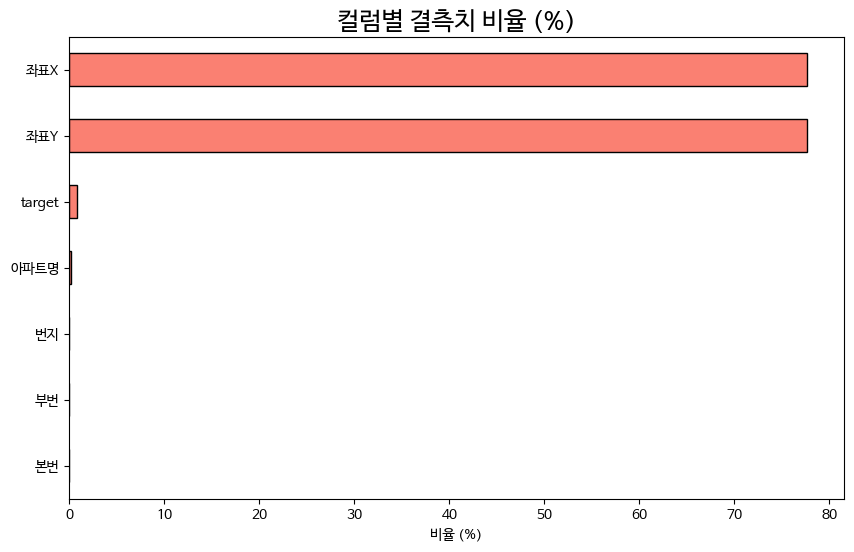

In [21]:
missing_percent = (concat_select.isnull().sum() / len(concat_select)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values()

plt.figure(figsize=(10,6))
missing_percent.plot(kind="barh", color="salmon", edgecolor="black")
plt.title("컬럼별 결측치 비율 (%)", fontsize=18)
plt.xlabel("비율 (%)")
plt.show()

## 번지 결측치 처리

In [22]:
# 번지 데이터 수동 작업
concat.loc[concat['번지'].isna(), ['아파트명']].value_counts()

아파트명         
서초포레스타2단지        152
힐스테이트 서초 젠트리스     75
Name: count, dtype: int64

In [23]:
concat.loc[concat['아파트명']=='힐스테이트 서초 젠트리스', '시군구']


60194     서울특별시 서초구 신원동
60195     서울특별시 서초구 신원동
60196     서울특별시 서초구 신원동
60197     서울특별시 서초구 신원동
60198     서울특별시 서초구 신원동
              ...      
720188    서울특별시 서초구 신원동
720189    서울특별시 서초구 신원동
720190    서울특별시 서초구 신원동
720191    서울특별시 서초구 신원동
720192    서울특별시 서초구 신원동
Name: 시군구, Length: 75, dtype: object

In [24]:
# 아파트명에 대한 번지 데이터 입력
concat_select.loc[concat_select['아파트명'] == '힐스테이트 서초 젠트리스', '번지'] = '557'
concat_select.loc[concat_select['아파트명'] == '서초포레스타2단지', '번지'] = '384'

In [25]:
concat_select.loc[concat_select['번지'].isna(), ['아파트명']].value_counts()

Series([], Name: count, dtype: int64)

In [26]:
concat_select.isnull().sum()

번지              0
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명         2136
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

## 아파트명 결측치 처리

In [27]:
concat_select['아파트명'] = concat_select.groupby('도로명')['아파트명'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [28]:
concat_select.isnull().sum()

번지              0
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명         2130
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

In [29]:
concat_select.loc[concat_select['도로명'] == '천호대로77다길 11-6', '아파트명'] = '해오름아파트'
concat_select.loc[concat_select['도로명'] == '동호로11마길 20-8', '아파트명'] = '성민아트'
concat_select.loc[concat_select['도로명'] == '여의대방로62길 24', '아파트명'] = '효성아파트'
concat_select.loc[concat_select['도로명'] == '국사봉1길 18', '아파트명'] = '상진빌딩'
concat_select.loc[concat_select['도로명'] == '동호로11바길 30-8', '아파트명'] = '석종아파트'
concat_select.loc[concat_select['도로명'] == '신수로 89', '아파트명'] = '신수동 자이언트 아파트'
concat_select.loc[concat_select['도로명'] == '양재대로71길 2-11', '아파트명'] = '올림픽아트빌'
concat_select.loc[concat_select['도로명'] == '청계천로 295', '아파트명'] = '동대문신발상가'
concat_select.loc[concat_select['도로명'] == '대학로7길 15-4', '아파트명'] = '연건동아파트'
concat_select.loc[concat_select['도로명'] == '강남대로27길 7-14', '아파트명'] = '한일인텔빌라'
concat_select.loc[concat_select['도로명'] == '명륜2길 9-14', '아파트명'] = '명륜2길 9-14'
concat_select.loc[concat_select['도로명'] == '동호로5길 12', '아파트명'] = '다다유크레스'
concat_select.loc[concat_select['도로명'] == '증산로23길 8-8', '아파트명'] = '우일아파트'
concat_select.loc[concat_select['도로명'] == '낙산성곽동길 35-1', '아파트명'] = '낙산성곽동길 35-1'
concat_select.loc[concat_select['도로명'] == '서리풀길 14', '아파트명'] = 'callia vill'
concat_select.loc[concat_select['도로명'] == '효령로 200', '아파트명'] = '효령로 200'
concat_select.loc[concat_select['도로명'] == '화곡로 176-5', '아파트명'] = '화곡로 176-5'
concat_select.loc[concat_select['도로명'] == '광나루로12길 5', '아파트명'] = '광나루로12길 5'
concat_select.loc[concat_select['도로명'] == '개운사길 83-15', '아파트명'] = '개운사길 83-15'
concat_select.loc[concat_select['도로명'] == '도곡로93길 23', '아파트명'] = '대치 르엘'
concat_select.loc[concat_select['도로명'] == '까치산로14길 26-13', '아파트명'] = '힐탑아파트'
concat_select.loc[concat_select['도로명'] == '양천로 677', '아파트명'] = '염창하이츠빌딩'
concat_select.loc[concat_select['도로명'] == '천호대로118길 10', '아파트명'] = '천호대로118길 10'
concat_select.loc[concat_select['도로명'] == '난계로15길 36-6', '아파트명'] = '난계로15길 36-6'
concat_select.loc[concat_select['도로명'] == '난계로15길 36-8', '아파트명'] = '난계로15길 36-8'
concat_select.loc[concat_select['도로명'] == '이문로35아길 16', '도로명'] = '이문로16길 35' 
concat_select.loc[concat_select['도로명'] == '이문로16길 35', '아파트명'] = '이문로16길 35'
concat_select.loc[concat_select['도로명'] == '마조로1길 45', '아파트명'] = '아파트'
concat_select.loc[concat_select['도로명'] == '성지3길 7', '아파트명'] = '성지3길 7'

In [30]:
concat_select.isnull().sum()

번지              0
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명         1822
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

In [31]:
concat_select['아파트명'] = concat_select.apply(lambda row: row['도로명'] if (row['시군구'] == '서울특별시 구로구 구로동' and pd.isna(row['아파트명']) and ('구로동로' in row['도로명'] or '도림로' in row['도로명'] or '디지털로' in row['도로명'])) else row['아파트명'], axis=1)

In [32]:
concat_select.isnull().sum()

번지              0
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명          200
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

In [33]:
concat_select.loc[concat_select['아파트명'].isna(),['번지','시군구', '도로명']].value_counts()
# 여기서부터 결측치 처리하자

번지       시군구             도로명        
1101-1   서울특별시 영등포구 대림동  도림천로19길 12     127
404-13   서울특별시 동대문구 장안동  천호대로77길 62      22
685-103  서울특별시 관악구 봉천동   당곡2길 109-11     21
828-76   서울특별시 강남구 역삼동   테헤란로10길 27      16
828-21   서울특별시 강남구 역삼동   테헤란로10길 25      14
Name: count, dtype: int64

In [35]:
concat_select.loc[(concat_select['도로명'] == '도림천로19길 12') & (concat_select['번지'] == '1101-1') , '아파트명']

82632     NaN
82633     NaN
82634     NaN
82635     NaN
82636     NaN
         ... 
835844    NaN
900290    NaN
900291    NaN
8041      NaN
8042      NaN
Name: 아파트명, Length: 127, dtype: object

아파트 결측치 수동작업

In [36]:
concat_select.loc[(concat_select['도로명'] == '도림천로19길 12') & (concat_select['번지'] == '1101-1') , '아파트명'] = '유탑유블레스'
concat_select.loc[(concat_select['도로명'] == '천호대로77길 62') & (concat_select['번지'] == '404-13') , '아파트명'] = 'INS새터아파트'
concat_select.loc[(concat_select['도로명'] == '당곡2길 109-11') & (concat_select['번지'] == '685-103') , '아파트명'] = '보람아파트'
concat_select.loc[(concat_select['도로명'] == '테헤란로10길 27') & (concat_select['번지'] == '828-76') , '아파트명'] = '뜨라네'
concat_select.loc[(concat_select['도로명'] == '테헤란로10길 25') & (concat_select['번지'] == '828-21') , '아파트명'] = '뜨라네'



In [37]:
concat_select.isnull().sum()

번지              0
층               0
is_test         0
계약년월            0
좌표Y        876232
아파트명            0
계약일             0
본번             75
부번             75
좌표X        876232
도로명             0
건축년도            0
target       9272
시군구             0
전용면적            0
dtype: int64

In [38]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [39]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['층', 'is_test', '계약년월', '좌표Y', '계약일', '좌표X', '건축년도', 'target', '전용면적']
범주형 변수: ['번지', '아파트명', '본번', '부번', '도로명', '시군구']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [40]:
# 결측치 없어 아래 수행할 필요 없음

# # 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# # 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [41]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

번지         0
층          0
is_test    0
계약년월       0
좌표Y        0
아파트명       0
계약일        0
본번         0
부번         0
좌표X        0
도로명        0
건축년도       0
target     0
시군구        0
전용면적       0
dtype: int64

In [42]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 15)


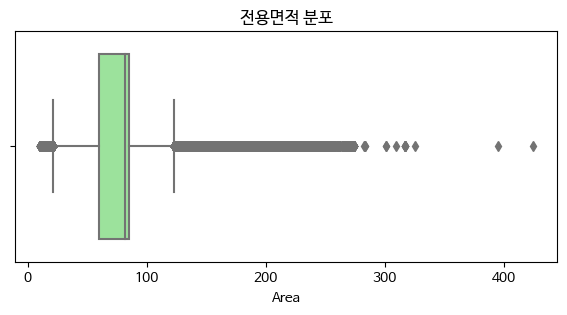

In [43]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [44]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1128094, 15)


In [45]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [46]:
concat_select['시군구'].map(lambda x : x.split()[2])

0       개포동
1       개포동
2       개포동
3       개포동
4       개포동
       ... 
9267    신내동
9268    신내동
9269    신내동
9270    신내동
9271    신내동
Name: 시군구, Length: 1128094, dtype: object

In [47]:
concat_select['계약년월'].astype('str').map(lambda x : x[:4])

0       2017
1       2017
2       2017
3       2018
4       2018
        ... 
9267    2023
9268    2023
9269    2023
9270    2023
9271    2023
Name: 계약년월, Length: 1128094, dtype: object

In [48]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [49]:
concat_select.columns

Index(['번지', '층', 'is_test', '좌표Y', '아파트명', '계약일', '본번', '부번', '좌표X', '도로명',
       '건축년도', 'target', '전용면적', '구', '동', '계약년', '계약월'],
      dtype='object')

In [50]:
concat_select.shape

(1128094, 17)

In [51]:
# ================================================================= #
# ✨ 1. [순서 변경] 시차(Lag) 적용 파생변수 생성 먼저 실행
# ================================================================= #


concat_select['계약년월'] = concat_select['계약년'] + concat_select['계약월'].str.zfill(2)

dt_rate['국고채_2y_lag'] = dt_rate['국고채'].shift(24)

# --- 1-3. 시차 적용된 데이터를 본 데이터에 병합 ---
dt_rate_lagged = dt_rate[['연월', '국고채_2y_lag']]
concat_select = pd.merge(concat_select, dt_rate_lagged, left_on='계약년월', right_on='연월', how='left')

# --- 1-4. 후처리 ---
concat_select = concat_select.drop(columns=['연월', '계약년월'])
concat_select['국고채_2y_lag'] = concat_select['국고채_2y_lag'].fillna(method='ffill').fillna(method='bfill')

print("\n✅ '국고채_2y_lag' 컬럼 추가 완료")


# ================================================================= #
# ✨ 2. [순서 변경] 불필요한 변수 제거 및 최종 데이터셋 생성
# ================================================================= #
# 모든 파생 변수 생성이 끝난 후, 이 시점에서 불필요한 변수를 제거합니다.
del_features = ['부번', '계약일', '계약월']
concat_select_ft = concat_select.drop(del_features, axis=1)

print("\n✅ 불필요한 변수 제거 완료")
print("최종 데이터셋 컬럼 확인:", concat_select_ft.columns)


✅ '국고채_2y_lag' 컬럼 추가 완료

✅ 불필요한 변수 제거 완료
최종 데이터셋 컬럼 확인: Index(['번지', '층', 'is_test', '좌표Y', '아파트명', '본번', '좌표X', '도로명', '건축년도',
       'target', '전용면적', '구', '동', '계약년', '국고채_2y_lag'],
      dtype='object')


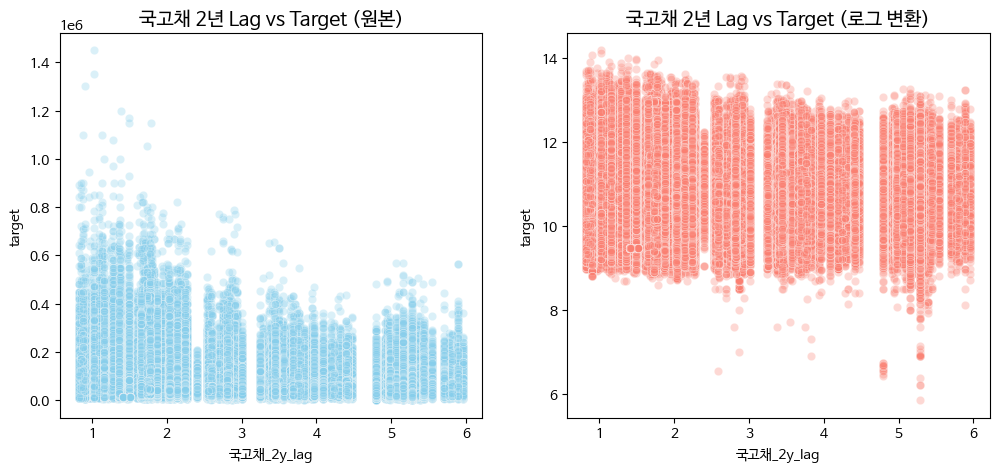

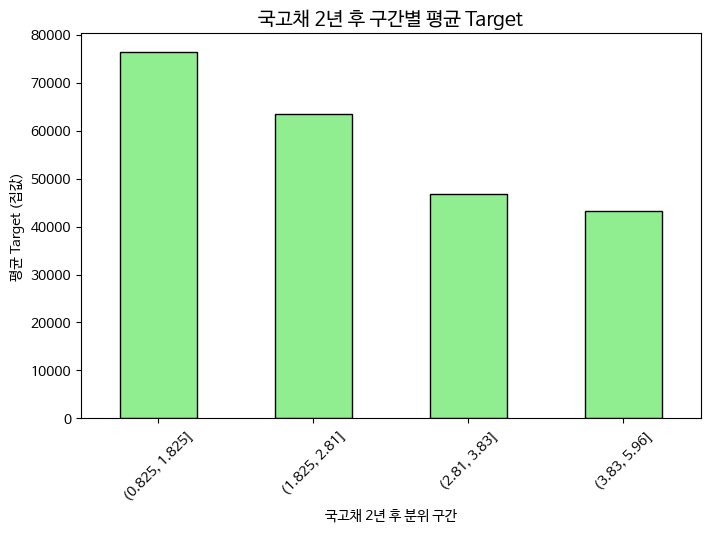

📊 국고채 2년 lag 분위수:
 0.25    1.825
0.50    2.810
0.75    3.830
Name: 국고채_2y_lag, dtype: float64


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# 1. 국고채 lag vs Target (산점도)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=concat_select_ft, x="국고채_2y_lag", y="target", alpha=0.3, color="skyblue")
plt.title("국고채 2년 Lag vs Target (원본)", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(data=concat_select_ft, x="국고채_2y_lag", y=np.log1p(concat_select_ft['target']), alpha=0.3, color="salmon")
plt.title("국고채 2년 Lag vs Target (로그 변환)", fontsize=14)

plt.show()

# =========================
# 2. 구간 나눔 (4분위)
# =========================
num_bins = 4
bins = pd.qcut(concat_select_ft["국고채_2y_lag"], q=num_bins, duplicates="drop")
bin_categories = bins.cat.categories

concat_select_ft["금리_bin"] = pd.cut(concat_select_ft["국고채_2y_lag"], bins=bin_categories)

# 구간별 평균 Target 계산
bin_target_mean = concat_select_ft.groupby("금리_bin")["target"].mean()

# =========================
# 3. 구간별 평균 Target 시각화
# =========================
plt.figure(figsize=(8,5))
bin_target_mean.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("국고채 2년 후 구간별 평균 Target", fontsize=14)
plt.xlabel("국고채 2년 후 분위 구간")
plt.ylabel("평균 Target (집값)")
plt.xticks(rotation=45)
plt.show()

# =========================
# 4. 분위수 값 출력
# =========================
quantiles = concat_select_ft["국고채_2y_lag"].quantile([0.25, 0.5, 0.75])
print("📊 국고채 2년 lag 분위수:\n", quantiles)


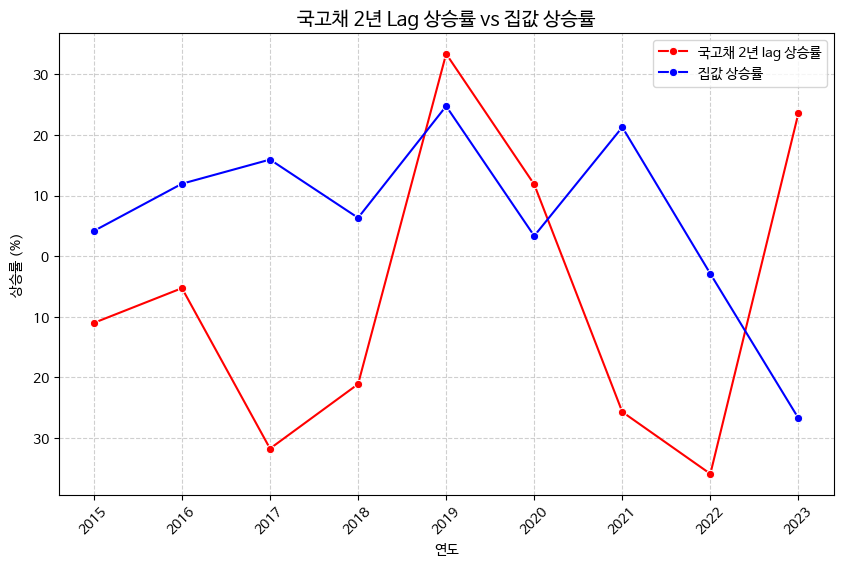

In [53]:
# =========================
# 1. 연도별 평균 집값(Target)과 평균 국고채_2y_lag 계산
# =========================
yearly_mean = concat_select_ft.groupby("계약년")[["target", "국고채_2y_lag"]].mean().reset_index()

# 계약년을 정수형으로 변환 (문자열이면 정렬이 꼬일 수 있음)
yearly_mean["계약년"] = yearly_mean["계약년"].astype(int)

# =========================
# 2. 전년 대비 상승률(%) 계산
# =========================
yearly_mean["국고채_상승률(%)"] = yearly_mean["국고채_2y_lag"].pct_change() * 100
yearly_mean["집값_상승률(%)"] = yearly_mean["target"].pct_change() * 100

# 첫 해 NaN 제거
yearly_mean = yearly_mean.dropna()

# =========================
# 3. 2015년 이후만 필터링
# =========================
yearly_mean = yearly_mean[yearly_mean["계약년"] >= 2015]

# =========================
# 4. 시각화
# =========================
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_mean, x="계약년", y="국고채_상승률(%)", label="국고채 2년 lag 상승률", marker="o", color="red")
sns.lineplot(data=yearly_mean, x="계약년", y="집값_상승률(%)", label="집값 상승률", marker="o", color="blue")

plt.title("국고채 2년 Lag 상승률 vs 집값 상승률", fontsize=14)
plt.xlabel("연도")
plt.ylabel("상승률 (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [54]:
del_features = ['부번', '계약일', '계약월']
concat_select_ft = concat_select.drop(del_features, axis=1)

print("\n✅ 불필요한 변수 제거 완료")
print("최종 데이터셋 컬럼 확인:", concat_select_ft.columns)



✅ 불필요한 변수 제거 완료
최종 데이터셋 컬럼 확인: Index(['번지', '층', 'is_test', '좌표Y', '아파트명', '본번', '좌표X', '도로명', '건축년도',
       'target', '전용면적', '구', '동', '계약년', '국고채_2y_lag'],
      dtype='object')


In [55]:
concat_select_ft.columns

Index(['번지', '층', 'is_test', '좌표Y', '아파트명', '본번', '좌표X', '도로명', '건축년도',
       'target', '전용면적', '구', '동', '계약년', '국고채_2y_lag'],
      dtype='object')

In [56]:
gu_list = list(concat_select_ft['구'].unique())
gu_list

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [57]:
concat_select_ft.groupby('구')['target'].count()

구
강남구      69656
강동구      62425
강북구      22137
강서구      67041
관악구      36243
광진구      22252
구로구      57983
금천구      19738
노원구     115837
도봉구      52872
동대문구     40068
동작구      40867
마포구      40810
서대문구     33272
서초구      53553
성동구      39831
성북구      57160
송파구      74444
양천구      54441
영등포구     48097
용산구      20682
은평구      38664
종로구       9184
중구       13534
중랑구      37303
Name: target, dtype: int64

In [58]:
gangnam_data = concat_select.loc[concat_select['구'] == '강남구']

# plt.figure(figsize=(15,12))
# plt.bar(gangnam_data['동'], gangnam_data['target'])
# plt.xlabel('구')
# plt.ylabel('price')
# plt.show()

## 5. Model Training

In [60]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select_ft.query('is_test==0')
dt_test = concat_select_ft.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 14) (9272, 14)


#### 전용면적 변수

In [61]:
num_bins = 4
bins = pd.qcut(dt_train['전용면적'], q=num_bins, duplicates='drop')
bin_categories = bins.cat.categories

dt_train['전용면적_bin'] = pd.cut(dt_train['전용면적'], bins=bin_categories)
dt_test['전용면적_bin'] = pd.cut(dt_test['전용면적'], bins=bin_categories)

bin_target_mean = dt_train.groupby('전용면적_bin')['target'].mean()
dt_train['전용면적_target_mean'] = dt_train['전용면적_bin'].map(bin_target_mean)
dt_test['전용면적_target_mean'] = dt_test['전용면적_bin'].map(bin_target_mean)

In [62]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

#### 범주형 인코딩

In [63]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

categorical_columns_v2.remove('구')
print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['층', '좌표Y', '좌표X', '건축년도', 'target', '전용면적', '국고채_2y_lag']
범주형 변수: ['번지', '아파트명', '본번', '도로명', '동', '계약년', '전용면적_bin', '전용면적_target_mean']


In [64]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


In [65]:
# one-hot encoding
features = ['구']

dt_train = pd.get_dummies(dt_train, columns=features)

dt_test = pd.get_dummies(dt_test, columns=features)

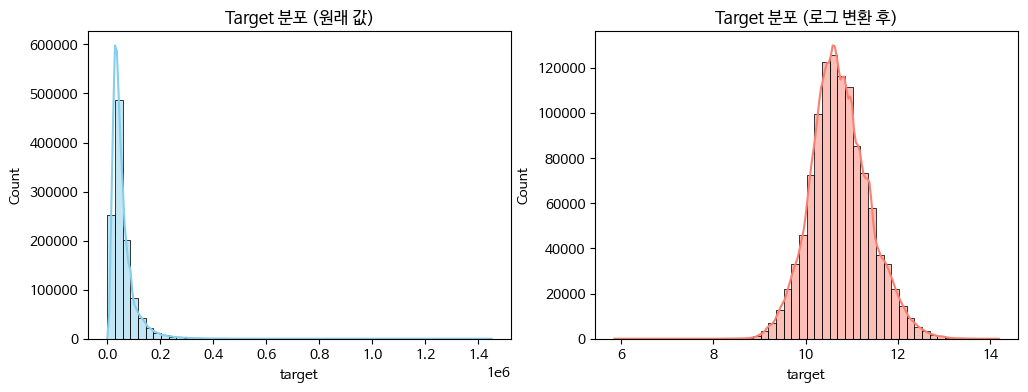

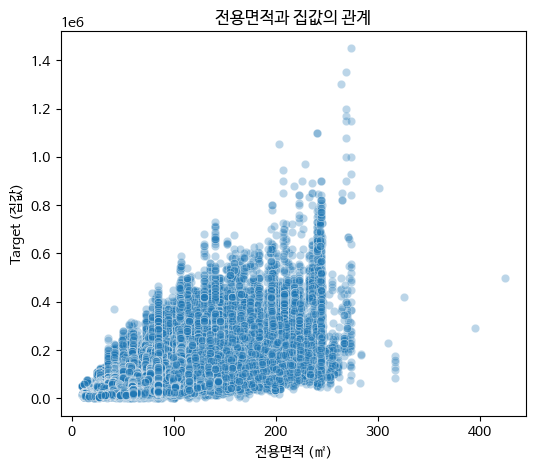

📊 전용면적 ↔ Target 상관계수 (피어슨): 0.577
📊 전용면적 ↔ Target 상관계수 (스피어만): 0.598


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# 1. 타겟값 분포 확인
# =========================
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(dt_train['target'], bins=50, kde=True, color="skyblue")
plt.title("Target 분포 (원래 값)")

plt.subplot(1,2,2)
sns.histplot(np.log1p(dt_train['target']), bins=50, kde=True, color="salmon")
plt.title("Target 분포 (로그 변환 후)")

plt.show()

# =========================
# 2. 전용면적 vs Target 관계
# =========================
plt.figure(figsize=(6,5))
sns.scatterplot(data=dt_train, x="전용면적", y="target", alpha=0.3)
plt.title("전용면적과 집값의 관계")
plt.xlabel("전용면적 (㎡)")
plt.ylabel("Target (집값)")
plt.show()

# =========================
# 3. 상관계수 계산
# =========================
corr_pearson = dt_train[['전용면적','target']].corr(method='pearson').iloc[0,1]
corr_spearman = dt_train[['전용면적','target']].corr(method='spearman').iloc[0,1]

print(f"📊 전용면적 ↔ Target 상관계수 (피어슨): {corr_pearson:.3f}")
print(f"📊 전용면적 ↔ Target 상관계수 (스피어만): {corr_spearman:.3f}")


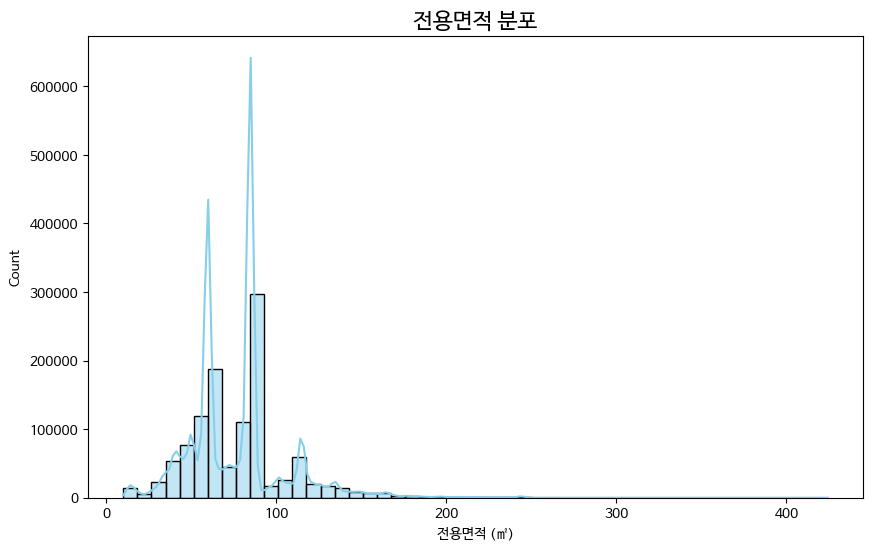

전용면적 주요 분위수:
 0.25     59.65
0.50     81.88
0.75     84.96
0.90    114.88
0.95    131.40
Name: 전용면적, dtype: float64


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(dt_train['전용면적'], bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title("전용면적 분포", fontsize=16)
plt.xlabel("전용면적 (㎡)")
plt.ylabel("Count")
plt.show()

# 사분위수 확인
quantiles = dt_train['전용면적'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print("전용면적 주요 분위수:\n", quantiles)


In [68]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# 모델 구분

#### LGBM MODEL

In [75]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ---------------------------
# TimeSeriesSplit 정의
# ---------------------------
kf = TimeSeriesSplit(n_splits=5)

# Target과 독립변수 분리
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# float 변환
X_train = X_train.astype(float)
X_test = dt_test.drop(['target'], axis=1).astype(float)

# ---------------------------
# 학습 진행
# ---------------------------
fold_save_files = []
cv_results = []

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n-------- {fold_idx}번째 fold 학습 시작 --------")

    # index로 데이터 분리
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = y_train.iloc[valid_idx]

    # CSV 저장 후 numpy 로드
    X_train_fold.to_csv(f'X_train_fold_{fold_idx}.csv', index=False)
    Y_train_fold.to_csv(f'Y_train_fold_{fold_idx}.csv', index=False, header=True)
    X_valid_fold.to_csv(f'X_valid_fold_{fold_idx}.csv', index=False)
    Y_valid_fold.to_csv(f'Y_valid_fold_{fold_idx}.csv', index=False, header=True)

    X_train_fold_np = np.loadtxt(f'X_train_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    Y_train_fold_np = np.loadtxt(f'Y_train_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    X_valid_fold_np = np.loadtxt(f'X_valid_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    Y_valid_fold_np = np.loadtxt(f'Y_valid_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)

    if Y_train_fold_np.ndim > 1: 
        Y_train_fold_np = Y_train_fold_np.ravel()
    if Y_valid_fold_np.ndim > 1: 
        Y_valid_fold_np = Y_valid_fold_np.ravel()

    # 모델 학습
    gbm = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=15,
        max_depth=10,
        min_child_samples=50,
        min_child_weight=1e-3,
        feature_fraction=0.6,
        bagging_fraction=0.6,
        bagging_freq=1,
        lambda_l1=2.0,   # L1 규제
        lambda_l2=5.0,   # L2 규제
        random_state=42,
        n_jobs=-1
    )
    gbm.fit(
        X_train_fold_np, Y_train_fold_np,
        eval_set=[(X_valid_fold_np, Y_valid_fold_np)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=100)]
    )

    # 예측
    y_train_pred = gbm.predict(X_train_fold_np, num_iteration=gbm.best_iteration_)
    y_valid_pred = gbm.predict(X_valid_fold_np, num_iteration=gbm.best_iteration_)

    # RMSE 계산
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    cv_results.append({
        "fold": fold_idx,
        "train_RMSE": rmse_train,
        "valid_RMSE": rmse_valid
    })

    print(f"✅ Fold {fold_idx} | Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # 모델 저장
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    fold_save_files.append(file_name)

# ---------------------------
# 교차검증 결과 요약
# ---------------------------
cv_df = pd.DataFrame(cv_results)
print("\n======== 교차검증 결과 요약 ========")
print(cv_df)

print("\n평균 Train RMSE:", cv_df["train_RMSE"].mean())
print("평균 Valid RMSE:", cv_df["valid_RMSE"].mean())
print("최적(가장 낮은) Valid RMSE:", cv_df["valid_RMSE"].min())



-------- 0번째 fold 학습 시작 --------


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[Ligh

#### RF MODEL

In [77]:
print("\n🌳 RandomForest 교차검증 시작\n")
rf_results, rf_files = [], []

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n======== [RF] Fold-{fold_idx} ========")

    # 데이터 분할
    X_train_fold = X_train.iloc[train_idx, :].copy()
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :].copy()
    Y_valid_fold = y_train.iloc[valid_idx]

    # numpy 변환
    X_train_fold_np, Y_train_fold_np = X_train_fold.to_numpy(), Y_train_fold.to_numpy()
    X_valid_fold_np, Y_valid_fold_np = X_valid_fold.to_numpy(), Y_valid_fold.to_numpy()

    # 모델 정의 및 학습
    # 모델 정의 (규제 효과 포함)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.5,
        max_samples=0.8,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_fold_np, Y_train_fold_np
           )

    # 예측
    y_train_pred = rf.predict(X_train_fold_np)
    y_valid_pred = rf.predict(X_valid_fold_np)

    # RMSE
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    rf_results.append({"fold": fold_idx, "train_RMSE": rmse_train, "valid_RMSE": rmse_valid})
    print(f"✅ Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # 모델 저장
    file_name = f"rf_fold{fold_idx}.pkl"
    joblib.dump(rf, file_name)
    rf_files.append(file_name)

rf_df = pd.DataFrame(rf_results)
print("\n📊 RandomForest 교차검증 결과\n", rf_df)
print("평균 Valid RMSE:", rf_df["valid_RMSE"].mean())
print("최적 Valid RMSE:", rf_df["valid_RMSE"].min())



🌳 RandomForest 교차검증 시작


======== [RF] Fold-0 ========
✅ Train RMSE: 7,867 | Valid RMSE: 42,050

======== [RF] Fold-1 ========
✅ Train RMSE: 11,337 | Valid RMSE: 20,142

======== [RF] Fold-2 ========
✅ Train RMSE: 10,658 | Valid RMSE: 8,302

======== [RF] Fold-3 ========
✅ Train RMSE: 9,575 | Valid RMSE: 7,777

======== [RF] Fold-4 ========
✅ Train RMSE: 8,878 | Valid RMSE: 9,020

📊 RandomForest 교차검증 결과
    fold    train_RMSE    valid_RMSE
0     0   7866.958982  42050.109435
1     1  11337.213723  20142.393423
2     2  10657.621178   8302.397450
3     3   9575.268176   7776.897015
4     4   8878.060617   9019.913213
평균 Valid RMSE: 17458.34210725603
최적 Valid RMSE: 7776.897015251229


#### XGBoost MODEL

In [79]:
import xgboost as xgb

print("\n🌳 XGBoost 교차검증 시작\n")
xgb_results, xgb_files = [], []

# TimeSeriesSplit 루프는 그대로 사용합니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n======== [XGB] Fold-{fold_idx} ========")

    # 1. 데이터 분할 및 numpy 변환 (기존과 동일)
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = y_train.iloc[valid_idx]

    X_train_fold_np, Y_train_fold_np = X_train_fold.to_numpy(), Y_train_fold.to_numpy()
    X_valid_fold_np, Y_valid_fold_np = X_valid_fold.to_numpy(), Y_valid_fold.to_numpy()

    # 2. XGBoost 전용 데이터 형식(DMatrix)으로 변환
    dtrain = xgb.DMatrix(X_train_fold_np, label=Y_train_fold_np, feature_names=list(X_train.columns))
    dvalid = xgb.DMatrix(X_valid_fold_np, label=Y_valid_fold_np, feature_names=list(X_train.columns))


    # 3. 모델 파라미터 정의 (RandomForest 규제 방식 참고)
    # RandomForest의 규제 파라미터를 XGBoost에 맞게 변환했습니다.
    params = {
        'objective': 'reg:squarederror', # 회귀 문제 정의
        'eval_metric': 'rmse',           # 평가 지표
        'eta': 0.02,                     # 학습률 (learning_rate)
        'max_depth': 7,                 # 트리 최대 깊이 (RF의 max_depth)
        'min_child_weight': 10,          # 리프 노드의 최소 데이터 수 (RF의 min_samples_leaf)
        'subsample': 0.8,                # 데이터 샘플링 비율 (RF의 max_samples)
        'colsample_bytree': 0.8,         # 피처(컬럼) 샘플링 비율 (RF의 max_features와 유사)
        'gamma': 0.1,                    # <-- 규제 추가
        'lambda': 2,                     # <-- L2 규제 추가
        'alpha': 1,                      # <-- L1 규제 추가
        'seed': 42
    }

    # 4. 모델 학습 (xgb.train 사용 및 조기 종료)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1500,        # 최대 트리 개수 (n_estimators)
        evals=watchlist,
        early_stopping_rounds=30,    # 30 라운드 동안 성능 향상 없으면 조기 종료
        verbose_eval=100             # 100 라운드마다 로그 출력
    )

    # 5. 예측
    # 최적의 트리 개수 (best_iteration)로 예측합니다.
    y_train_pred = xgb_model.predict(dtrain, iteration_range=(0, xgb_model.best_iteration))
    y_valid_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration))


    # 6. RMSE 계산 (기존과 동일)
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    xgb_results.append({"fold": fold_idx, "train_RMSE": rmse_train, "valid_RMSE": rmse_valid})
    print(f"✅ Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # 7. 모델 저장 (기존과 동일)
    file_name = f"xgb_fold{fold_idx}.pkl"
    joblib.dump(xgb_model, file_name)
    xgb_files.append(file_name)


# 교차검증 결과 요약 (기존과 동일)
xgb_df = pd.DataFrame(xgb_results)
print("\n📊 XGBoost 교차검증 결과\n", xgb_df)
print("\n평균 Train RMSE:", xgb_df["train_RMSE"].mean())
print("평균 Valid RMSE:", xgb_df["valid_RMSE"].mean())
print("최적 Valid RMSE:", xgb_df["valid_RMSE"].min())


🌳 XGBoost 교차검증 시작


======== [XGB] Fold-0 ========
[0]	train-rmse:41453.21029	eval-rmse:72741.92672
[100]	train-rmse:16190.76219	eval-rmse:48729.53781
[200]	train-rmse:11983.17534	eval-rmse:43551.52287
[300]	train-rmse:10640.01272	eval-rmse:41839.90145
[400]	train-rmse:9915.72063	eval-rmse:41225.09112
[500]	train-rmse:9362.92004	eval-rmse:40884.57221
[600]	train-rmse:8898.80407	eval-rmse:40675.03867
[700]	train-rmse:8520.01862	eval-rmse:40491.71932
[800]	train-rmse:8211.33126	eval-rmse:40377.68411
[900]	train-rmse:7917.58606	eval-rmse:40244.02016
[1000]	train-rmse:7670.53834	eval-rmse:40165.24436
[1100]	train-rmse:7464.63897	eval-rmse:40082.95271
[1200]	train-rmse:7274.07656	eval-rmse:40021.08876
[1300]	train-rmse:7112.58315	eval-rmse:39952.59363
[1400]	train-rmse:6968.95067	eval-rmse:39918.66906
[1444]	train-rmse:6910.23597	eval-rmse:39914.26663
✅ Train RMSE: 6,949 | Valid RMSE: 39,913

======== [XGB] Fold-1 ========
[0]	train-rmse:56837.98541	eval-rmse:48260.66345
[100]	train-rmse:2